# Axon Initial Segment: Multiple Models

<img src="Imageanalysis.png/png" alt='Drawing' style="width: 500px;"/>

#### Overview:

The data provides us with measurements of the Axon Initial Segment (AIS). Panels A' and B' panel above show traces measured from raw images A & B. This data comes from multiple pre-clinical models of autism spectrum disorder and documents parameters such as location of experiment, genetic mutation (i.e. pre-clinical model), age, gender, parent and background strain. The data appears to be from the same brain region.

#### Hypothesis:

Do mutations from different pre-clinical models (or genotypes) cause the same alterations in AIS length? Therefore, could targetting this structure be a one-size fits all model for further therapeutic intervention? What are the contributions of non-genotype factors on AIS length variance and could these explain any differences in length seen?

#### EDA:

After initial EDA we found that the data had no null values. Columns 'Brain region' & 'Species' had only 1 unique value and therefore did not offer any basis for comparison and were dropped. 

Initial descriptive statistics of the target variable 'AIS length' showed the range of values to lie between 13.48 to 46.97 $\mu$m with a mean value of 29.43 $\mu$m, which is within the biological range. The data also has a small negative skew (-0.036) and positive kurtosis (0.221) suggesting a near normal distribution. Outlier analysis using z-scores did detect some outliers in AIS length. However, as it is unkown how mutations might affect length and all values were within an acceptable biological range, no values were discarded.

__Initial findings:__
1. Location and Gender do not have any mean differences and are therefore not analysed further.
2. The main interaction of interest is that of Model x Genotype.
3. The differences in *Strain* may be driven by a specific Model, Genotype, or both, and is further analysed as such.
4. Given that there are too many *Parents* to be correctly assesed in the EDA, these graphs need to be separated by Model to get a better sense of differential distribution within Model.
5. Similarly, *Sample-IDs* are numerous and should be viewed within Model and Genotype to see if the values from one sample are biasing any Genotype differences observed.
6. Finally, *Age* 32 seems to have shorter average AIS lenghts compared to the other ages. This should be viewed in the context of class imbalance within Ages, Genotype and Model.

#### Overall Assessment:


#### Next steps

Having run the initial comparisons of factors, to accurately attribute any differences in length purely to genotype we must run a mixed effects model with the appropriate fixed and random variables. To see an example of this run within the Fmr1 model please see the AIS_GLMM notebook.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('Datasets/ais_mPFC L5_GLMM template.xlsx')
df = pd.DataFrame(df)
df.head(5)

,Species,Model,Strain,Brain region,Sample ID,Genotype,Age,Parent,Gender,Location,AIS length
0,R. Nor.,Fmr1,LE,mPFC L5,214,WT,27,Fmr1/GFP19,M,BLR,23.855
1,R. Nor.,Fmr1,LE,mPFC L5,214,WT,27,Fmr1/GFP19,M,BLR,27.164
2,R. Nor.,Fmr1,LE,mPFC L5,214,WT,27,Fmr1/GFP19,M,BLR,26.665
3,R. Nor.,Fmr1,LE,mPFC L5,214,WT,27,Fmr1/GFP19,M,BLR,22.786
4,R. Nor.,Fmr1,LE,mPFC L5,214,WT,27,Fmr1/GFP19,M,BLR,22.191


## Exploratory data analysis

In [3]:
print('Data info is')
df.info()

Data info is
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6395 entries, 0 to 6394
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Species       6395 non-null   object 
 1   Model         6395 non-null   object 
 2   Strain        6395 non-null   object 
 3   Brain region  6395 non-null   object 
 4   Sample ID     6395 non-null   int64  
 5   Genotype      6395 non-null   object 
 6   Age           6395 non-null   int64  
 7   Parent        6395 non-null   object 
 8   Gender        6395 non-null   object 
 9   Location      6395 non-null   object 
 10  AIS length    6395 non-null   float64
dtypes: float64(1), int64(2), object(8)
memory usage: 549.7+ KB


In [4]:
print('Column unique values are')
df.nunique() #No of unique values per column

Column unique values are


Species            1
Model              6
Strain             2
Brain region       1
Sample ID         69
Genotype           4
Age                5
Parent            22
Gender             2
Location           2
AIS length      5487
dtype: int64

In [5]:
df.drop(['Species', 'Brain region'], axis=1, inplace=True) #Drop columns with unique vcalues =1
df.head(5)

,Model,Strain,Sample ID,Genotype,Age,Parent,Gender,Location,AIS length
0,Fmr1,LE,214,WT,27,Fmr1/GFP19,M,BLR,23.855
1,Fmr1,LE,214,WT,27,Fmr1/GFP19,M,BLR,27.164
2,Fmr1,LE,214,WT,27,Fmr1/GFP19,M,BLR,26.665
3,Fmr1,LE,214,WT,27,Fmr1/GFP19,M,BLR,22.786
4,Fmr1,LE,214,WT,27,Fmr1/GFP19,M,BLR,22.191


### Visual Inspection of data
Overall Data looks normally distributed

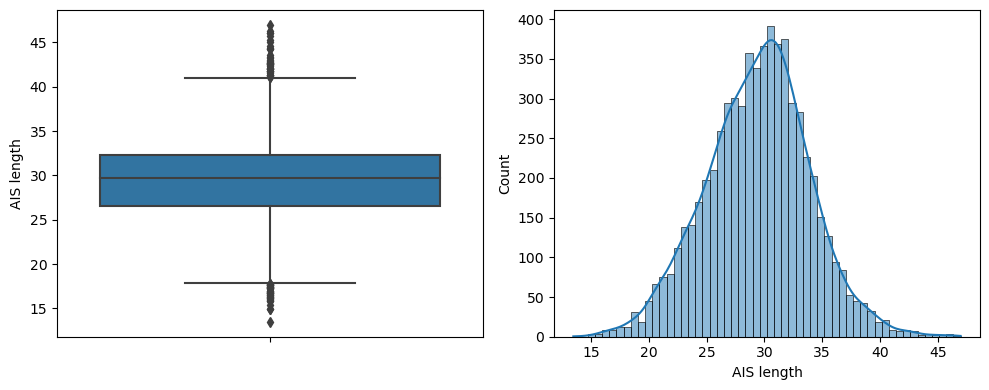

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

sns.boxplot(df, y='AIS length', ax=axs[0])
sns.histplot(df, x='AIS length', kde=True, ax=axs[1])

plt.tight_layout()
plt.show()

In [7]:
def data_col_overview(df, y_plt):
    num_cols = df.shape[1] # No. of columns in dataframe
    num_rows = int(np.ceil(num_cols / 4)) #divide this to get even dsitribution of rows
    
    fig, axs = plt.subplots(num_rows, 4, figsize=(20,15)) # Adjust figsize as needed
    fig.suptitle('Overview: All Columns', fontsize=16)
    axs = axs.flatten()#flatten axis for easy indexing
    
    for i, col in enumerate(df.columns):
        sns.boxplot(data=df, x=col, y=y_plt, ax=axs[i], palette='husl')
    
    for j in range(num_cols, num_rows * 4): # Remove any extra empty subplots
        fig.delaxes(axs[j])
    plt.show()

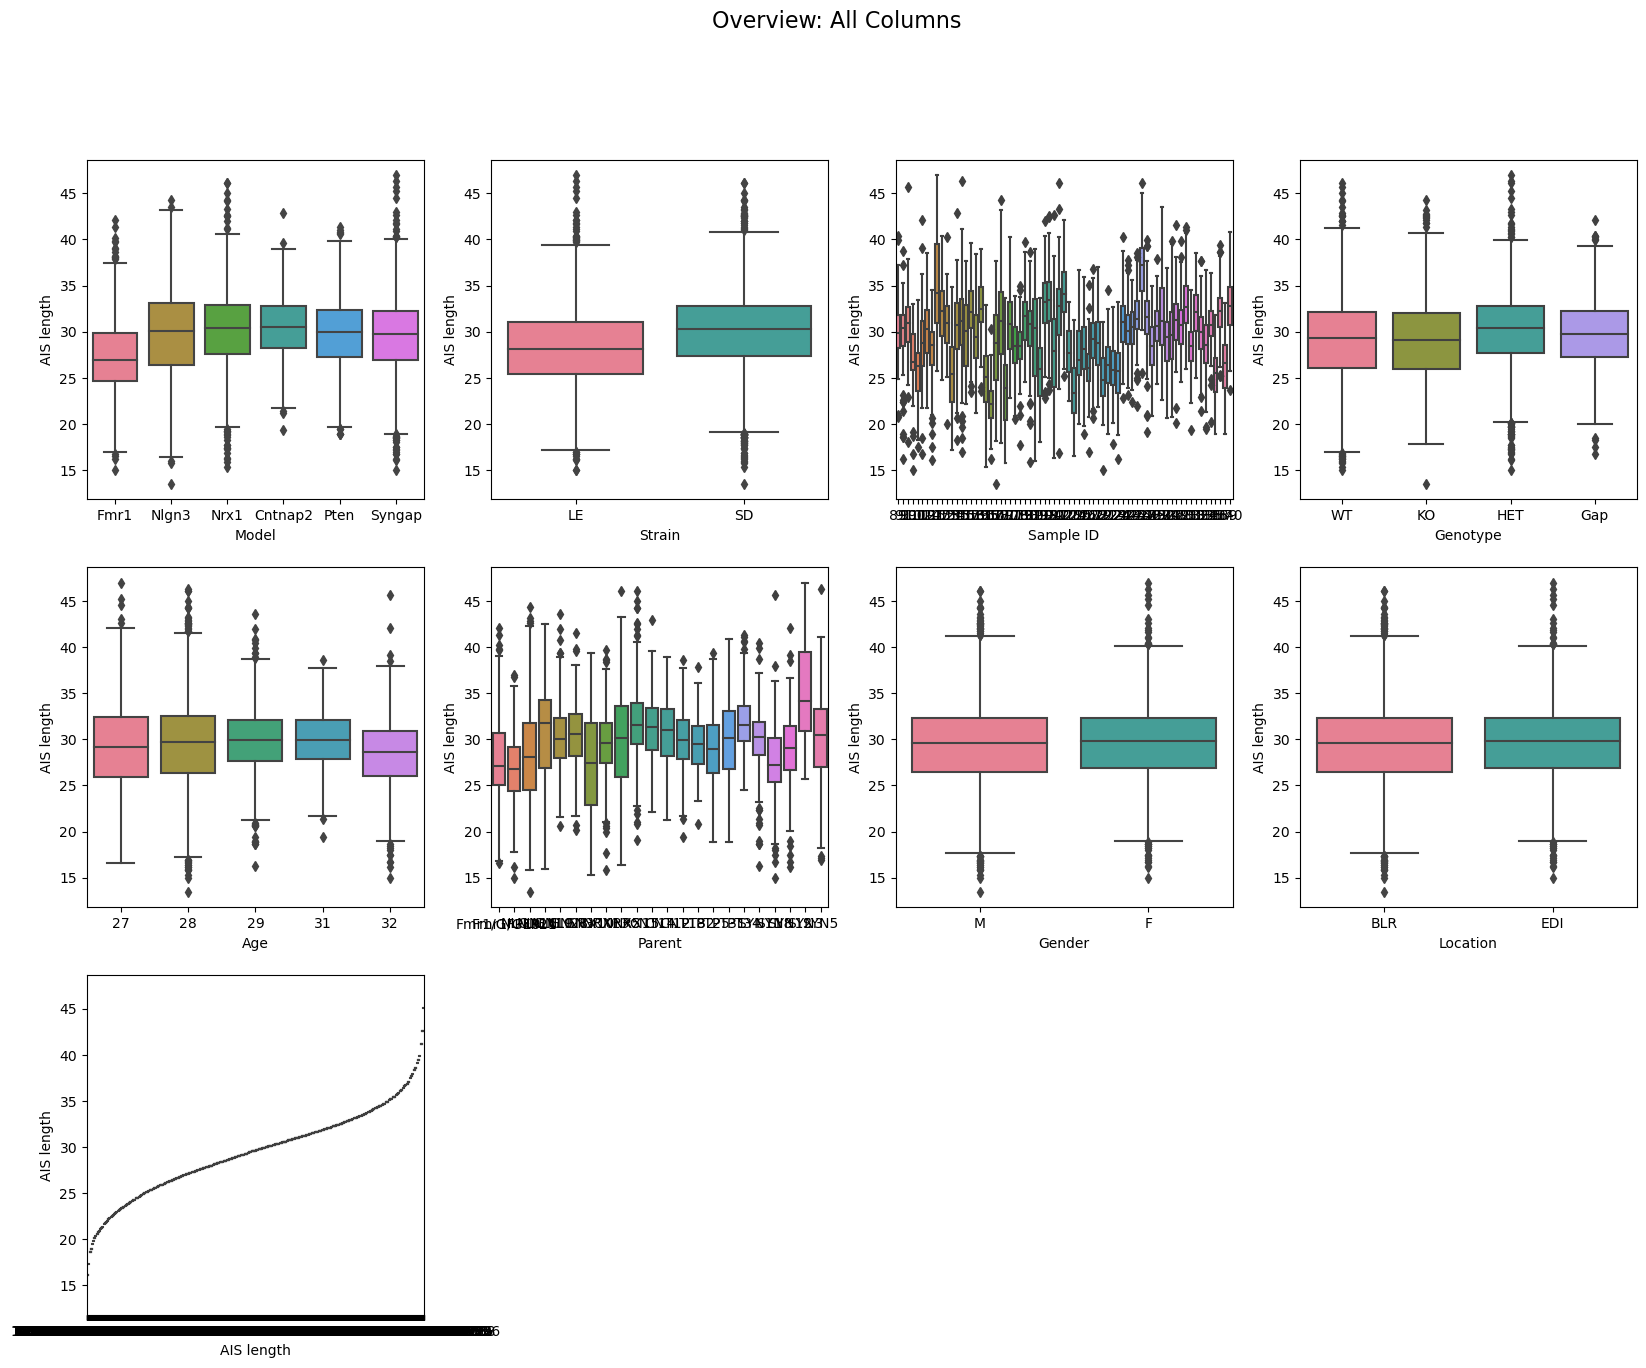

In [8]:
data_col_overview(df, df['AIS length'])

#### Descriptive Stats & Outlier Detection

In [9]:
x = df['AIS length']

print (stats.describe(x)) 
print (f'Standard error is {stats.sem(x)}, while Standard Deviation is {stats.tstd(x)}')

DescribeResult(nobs=6395, minmax=(13.48, 46.97), mean=29.43219335295091, variance=19.958291836244054, skewness=-0.03614189069281572, kurtosis=0.22148490378094365)
Standard error is 0.055865206696062215, while Standard Deviation is 4.467470406868305


In [10]:
#Z-score method for outlier detection
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(message)s')
logger = logging.getLogger()

a = stats.zscore(df['AIS length'])#Calculate z-score
outliers=[]#empty list to append outliers

for idx, value in enumerate(a):
    if value <-3: #Setting +-3 std.devs as threshold
        outliers.append((idx, df['Model'].iloc[idx], df['Genotype'].iloc[idx], value, 'too small'))
    elif value >3:
        outliers.append((idx, df['Model'].iloc[idx], df['Genotype'].iloc[idx], value, 'too large'))
        
if outliers:
    print(f"{'Index':<10} {'Model':<15} {'Genotype':<15} {'Z-score':<10} {'Remark':<10}")#Numbers indicate length of field
    print("="*64)#Dashed line values increased for better formatting
    for outlier in outliers:
        print(f"{outlier[0]:<10} {outlier[1]:<15} {outlier[2]:<15} {outlier[3]:<10.2f} {outlier[4]:<10}")#.2f is the no of decimal places with a flaoting point representation
else:
    print("No outliers found.")

Index      Model           Genotype        Z-score    Remark    
856        Fmr1            WT              -3.24      too small 
1221       Nlgn3           WT              -3.05      too small 
1243       Nlgn3           KO              -3.57      too small 
1357       Nlgn3           KO              3.33       too large 
1427       Nlgn3           KO              3.08       too large 
1617       Nlgn3           WT              -3.02      too small 
1907       Nlgn3           WT              3.16       too large 
2343       Nrx1            WT              -3.16      too small 
2705       Nrx1            WT              -3.04      too small 
2894       Nrx1            HET             3.10       too large 
2915       Nrx1            HET             3.73       too large 
3338       Nrx1            WT              3.50       too large 
3379       Nrx1            WT              3.32       too large 
3388       Nrx1            WT              3.72       too large 
3407       Nrx1          

## Pre-lim Assessment:

1. Overall we see that Location and Gender do not have any stark differences and can therefore dropped.
2. The main interaction of interest is that of Model x Genotype. We analyse this first.
3. The differences in *Strain* need to may be driven by a specific Model, Genotype, or both
4. Given that there are too many *Parents*, these graphs need to be separated by Model to get a better sense of distribution.
5. Similarly, *Sample-IDs* are numerous and should be viewed within Model and Genotype to see if the values from one sample are biasing any Genotype differences observed
6. Finally, *Age* 32 seems to have shorter average AIS lenghts compared to the other ages. This should be viewed in the context of class imbalance, Genotype and Model 

### Analysing the Model x Genotype interaction

No clear consensus of effect of genotype on AIS length, effects seem to vary by model. Models Fmr1, Cntnap2, and Pten show right-shifted (or increased proportion of 'longer') AIS length distributions, while models Nlgn3, Nrx1 and Syngap show left-shifted (or increased proportion of 'shorter') AIS length distributions. 

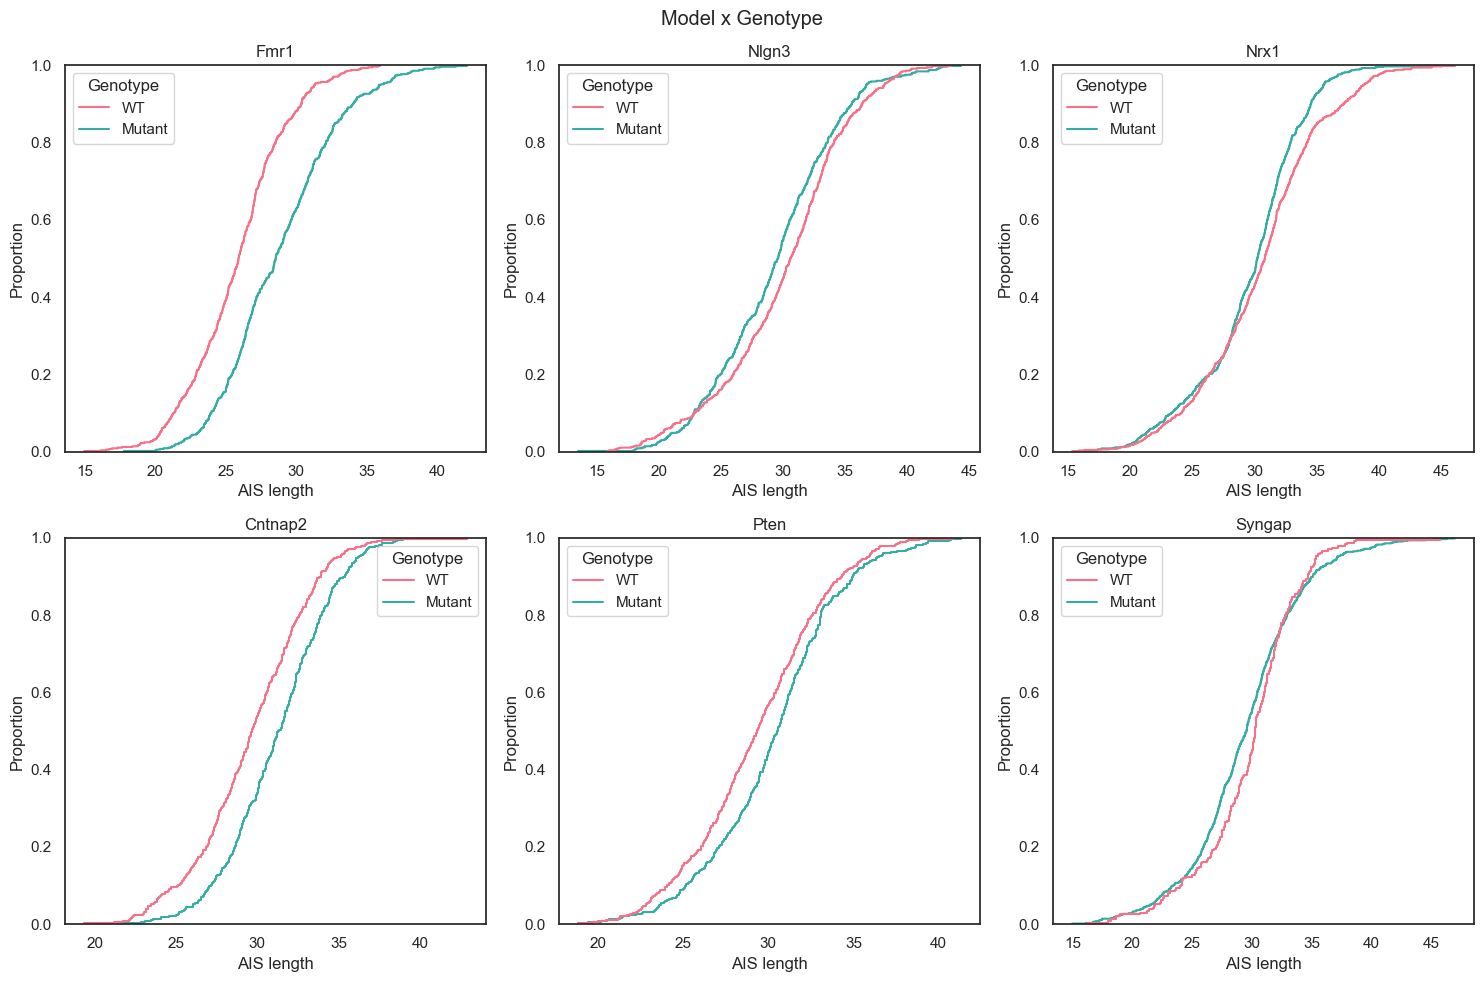

In [11]:
df['Genotype'].replace({'KO': 'Mutant', 'HET': 'Mutant', 'Gap':'Mutant'}, inplace=True)

sns.set_theme(style='white')
fig, axs = plt.subplots(2, 3, figsize=(15,10))
fig.suptitle('Model x Genotype')
axs = axs.flatten()


for i, value in enumerate(df['Model'].unique()):
    sns.ecdfplot(data=df[df['Model']== value], x='AIS length', hue='Genotype', hue_order=('WT', 'Mutant'), stat='proportion', palette={'WT':'#f77189', 'Mutant': '#36ada4'}, ax=axs[i])
    axs[i].set_title(f'{value}')
    
plt.tight_layout()
plt.show()

#### Analysing *Strain*: _By Model_
We see that differences observed in the 'Strain' Average AIS length are driven by the 'Fmr1' model

<Axes: xlabel='Strain', ylabel='AIS length'>

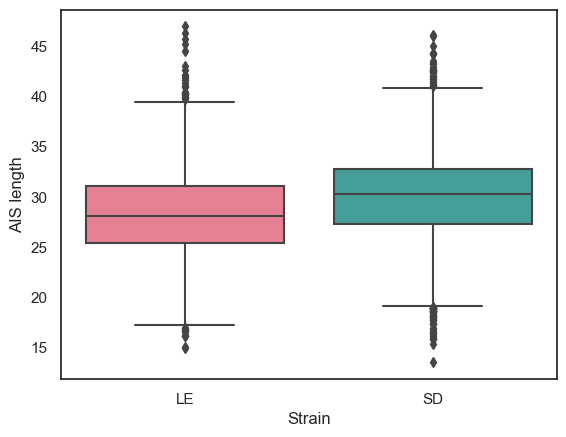

In [12]:
sns.boxplot(
    df, 
    x='Strain', y='AIS length', palette='husl'
)

In [13]:
df['Model_Strain'] = df['Model'] + ' - ' + df['Strain']
model_strain_order = ['Fmr1-LE', 'Syngap-LE', 'Cntnap2-SD', 'Nrx1-SD', 'Nlgn3-SD', 'Pten-SD'] #Creating model order to have the same strains next to each other for ease of viewing
# Convert the 'Model' column to a categorical type with the specified order
df['Model_Strain'] = pd.Categorical(df['Model_Strain'], categories=model_strain_order, ordered=True)

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


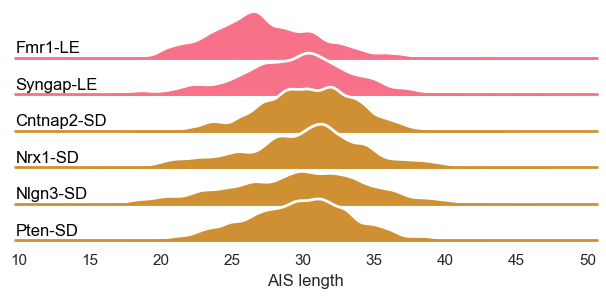

In [23]:
sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
pal = sns.husl_palette(8)

g = sns.FacetGrid(df, row="Model", hue='Strain', aspect=15, height=.5, palette=pal)
g.map(sns.kdeplot, 'AIS length',
      bw_adjust=.5, clip_on=False,
      fill=True, alpha=1, linewidth=1.5)

g.map(sns.kdeplot, 'AIS length', clip_on=False, color="w", lw=2, bw_adjust=.5)

g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

def label(ax, color, model_name):
    ax.text(0, .2, model_name, color=color,
            ha="left", va="center", transform=ax.transAxes)

# Apply the label function to each subplot
for ax, model in zip(g.axes.flat, df['Model_Strain'].cat.categories):
    label(ax, color='black', model_name=model)
g.figure.subplots_adjust(hspace=-.25)
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)

#### Analysing Strain: _By Genotype_
We see that Strain differences are driven by the 'WT' genotype.

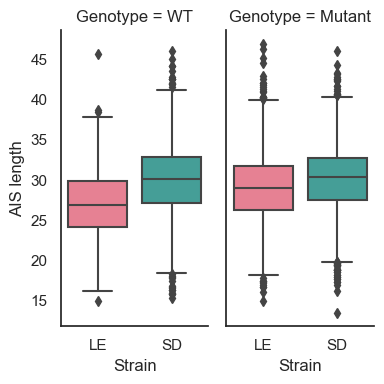

In [15]:
sns.catplot(
    df, kind='box',
    x='Strain', y='AIS length', col='Genotype', palette='husl',
    height=4, aspect=0.5
)

plt.show()

#### Analysing *Strain*: _By Model x Genotype_

If we take the WT and Mutant values separately, we see that the differences in WT are driven only by the Fmr1 model, while in the genotype Mutant, both Fmr1 and Syngap models have lower avg values

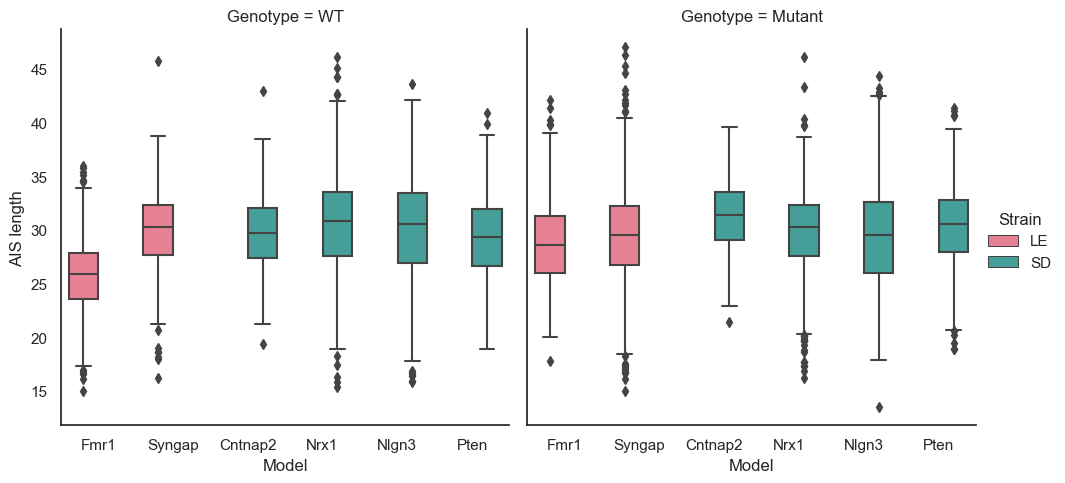

In [16]:
model_order = ['Fmr1', 'Syngap', 'Cntnap2', 'Nrx1', 'Nlgn3', 'Pten']

df['Model'] = pd.Categorical(df['Model'], categories=model_order, ordered=True)

sns.catplot(
    data=df, x='Model', y='AIS length', hue='Strain', col='Genotype',
    kind="box", palette='husl'
)

#### Analysing Parent

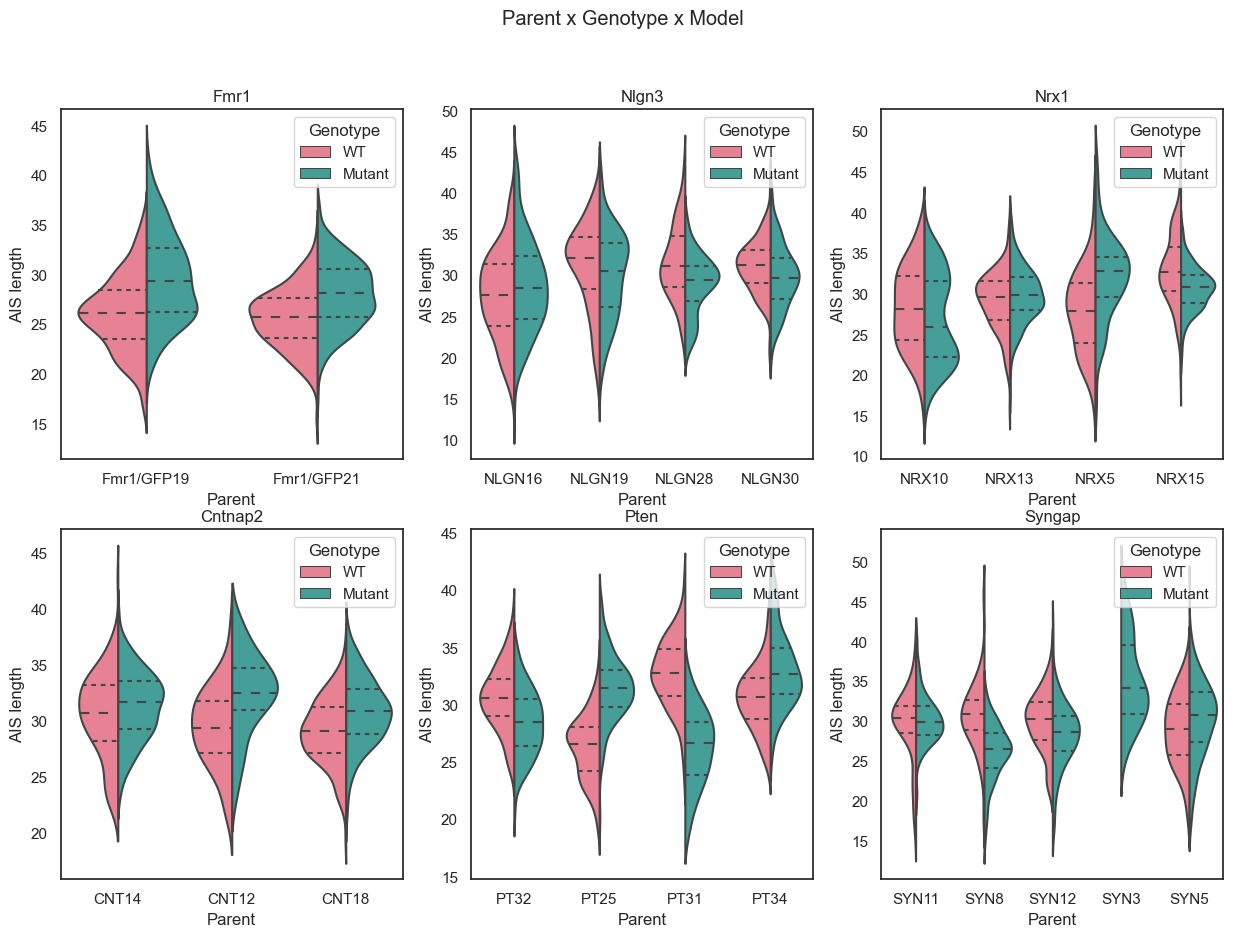

In [24]:
Parent_df = df[['Model', 'Parent', 'AIS length', 'Genotype']]
unique_values_Model = Parent_df['Model'].unique()

sns.set_theme(style="white")

fig, axs = plt.subplots(2, 3, figsize=(15,10)) # Adjust figsize as needed
fig.suptitle('Parent x Genotype x Model')
axs = axs.flatten() #flatten axis for easy indexing

for i, value in enumerate(unique_values_Model):
    sns.violinplot(data=Parent_df[Parent_df['Model'] == value], 
                   x='Parent', y='AIS length', hue='Genotype', hue_order=('WT', 'Mutant'), split=True, inner="quart", fill=False,
               palette={'WT':'#f77189', 'Mutant': '#36ada4'}, ax=axs[i])
    axs[i].set_title(f'{value}')
plt.show()

#### Analysing 'Sample-ID'

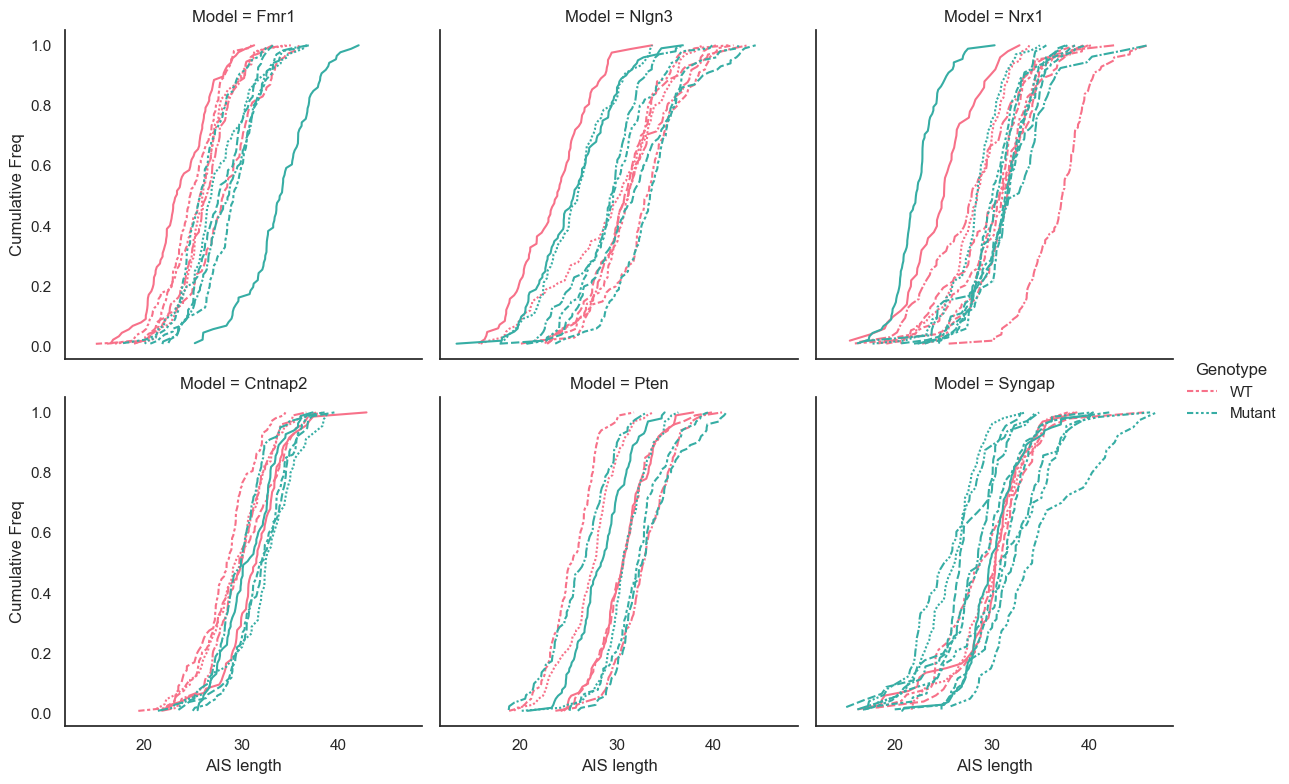

In [18]:
def ecdf(data):
    x = np.sort(data)
    n = len(data)
    y = np.arange(1, n + 1) / n
    return x, y


unique_models = df['Model'].unique()
all_ecdf_data = []

for model in unique_models:
    subset_models = df[df['Model'] == model]
    for sample_id in subset_models['Sample ID'].unique():
        subset_sample = subset_models[subset_models['Sample ID'] == sample_id]
        x, y = ecdf(subset_sample['AIS length'])
        ecdf_df = pd.DataFrame({
            'AIS length': x,
            'Cumulative Freq': y,
            'Model': model,
            'Genotype': subset_sample['Genotype'].values[0],  # Assuming one genotype per sample_id in this subset
            'Sample ID': sample_id
        })
        all_ecdf_data.append(ecdf_df)

# Concatenate all ECDF DataFrames
ecdf_df_combined = pd.concat(all_ecdf_data, ignore_index=True)

# Plotting using Seaborn
sns.set_theme(style='white')
g = sns.FacetGrid(data=ecdf_df_combined, col='Model', col_wrap=3, hue='Genotype', palette='husl', height=4)
g.map_dataframe(sns.lineplot, x='AIS length', y='Cumulative Freq', style='Sample ID')
g.add_legend()

plt.show()

#### Analysing Age

Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


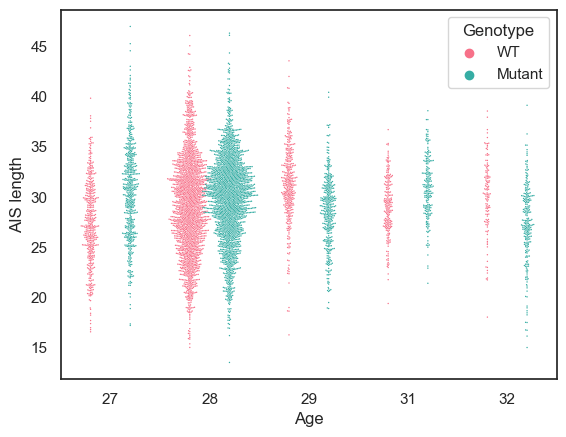

In [19]:
sns.swarmplot(df, x='Age', y='AIS length', hue='Genotype', palette='husl', dodge=True, size=1)
plt.show()

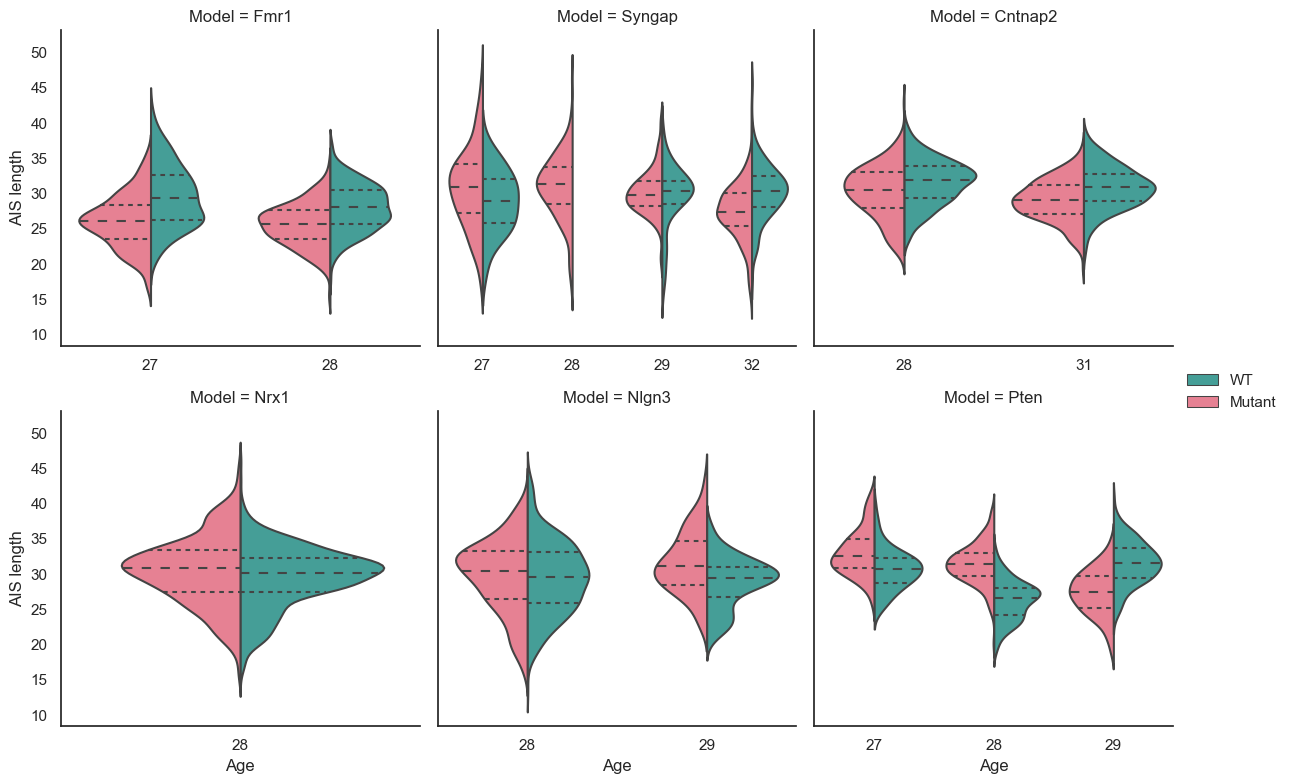

In [20]:
g=sns.FacetGrid(data=df, col='Model', col_wrap=3, sharex=False, height=4)
g.map_dataframe(sns.violinplot, x='Age', y='AIS length', hue='Genotype', palette='husl', split=True, inner='quart')
g.add_legend()
plt.show()